## Vehicle Detection Project

The main steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.



## Feature Extraction

## Train Classifier

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
# images are divided up into vehicles and non-vehicles
%matplotlib inline


### Read in training data

Your function returned a count of 8792  cars and 8792  non-cars
of size:  (64, 64, 3)  and data type: float32


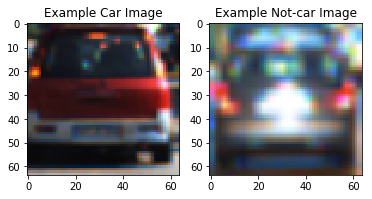

In [34]:
path_vehicles = './training_data/vehicles/'
path_non_vehicles = './training_data/vehicles/'

cars = glob.glob(path_vehicles+ '**/*.png', recursive=True)
notcars = glob.glob(path_non_vehicles+ '**/*.png', recursive=True)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

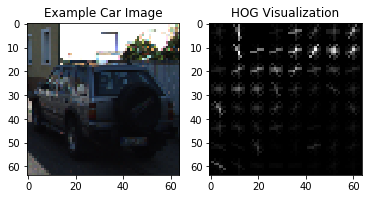

In [35]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, \
                                  orientations=orient, \
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                  cells_per_block=(cell_per_block, cell_per_block), \
                                  transform_sqrt=False, 
                                  visualise=True, \
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features            = hog(img, \
                                  orientations=orient, \
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                  cells_per_block=(cell_per_block, cell_per_block), \
                                  transform_sqrt=False, 
                                  visualise=False, \
                                  feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


## Sliding Window

## Run Pipeline on the Project Video Stream

In [30]:
def vehicle_detection_pipeline(img):
    return img

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
# process test video 
test_video_output = 'test_video_vehicle_detection.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_video_clip = clip1.fl_image(vehicle_detection_pipeline) #NOTE: this function expects color images!!
%time test_video_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video test_video_vehicle_detection.mp4
[MoviePy] Writing video test_video_vehicle_detection.mp4


 97%|█████████▋| 38/39 [00:00<00:00, 127.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_vehicle_detection.mp4 

CPU times: user 58.2 ms, sys: 52.8 ms, total: 111 ms
Wall time: 1.02 s


In [ ]:
# process project video 
if False:
    project_video_output = 'project_video_vehicle_detection.mp4'
    clip2 = VideoFileClip("project_video.mp4")
    project_video_clip = clip2.fl_image(vehicle_detection_pipeline) #NOTE: this function expects color images!!
    %time project_video_clip.write_videofile(project_video_output, audio=False)